In [78]:
from os.path import join as pjoin
import numpy as np
import pandas as pd
import runpy
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import functions from other scripts
file_globals = runpy.run_path('digit_classification.py')
get_digit_indices = file_globals['get_digit_indices']

# Load data

In [12]:
# load data
results_dir = '/data/BnB_USER/oliver/somato/scratch/crossval_projection'

# for first run is training, second is test
proj_data_run1train_npy = pjoin(results_dir, 'proj_run1_is_train.npy')
trained_srms_run1train_npy = pjoin(results_dir, 'trainedsrms_run1_is_train.npy')
with open(proj_data_run1train_npy, 'rb') as inf:
    proj_data_run1train = np.load(inf)
with open(trained_srms_run1train_npy, 'rb') as inf:
    trained_srms_run1train = np.load(inf)
    
# second run is training, first is test
proj_data_run2train_npy = pjoin(results_dir, 'proj_run2_is_train.npy')
trained_srms_run2train_npy = pjoin(results_dir, 'trainedsrms_run2_is_train.npy')

with open(proj_data_run2train_npy, 'rb') as inf:
    proj_data_run2train = np.load(inf)
with open(trained_srms_run1train_npy, 'rb') as inf:
    trained_srms_run2train = np.load(inf)

In [14]:
# create finger-color arrays

# get ndarrays (nfingers, nvols)
digits_run1, digits_run2 = get_digit_indices()

# turn into flat arrays with values 1-5
digit_colors_run1, digit_colors_run2 = np.zeros(shape=(256)), np.zeros(shape=(256))
for finger_i in range(1,6):
    digit_colors_run1[digits_run1[finger_i-1]] = finger_i
    digit_colors_run2[digits_run2[finger_i-1]] = finger_i

# for some reason, the first entry in the first run's digit array is a 5, but should be a 1...
digit_colors_run1[0]=1.

In [79]:
# make lists of data frames

# first run is training, second is test
projected_dfs_run2 = []
trained_srms_dfs_run1 = []

for sub_idx in range(proj_data_run1train.shape[0]):
    df = pd.DataFrame(proj_data_run1train[sub_idx].T)
    projected_dfs_run2.append(df)
    srm_df = pd.DataFrame(trained_srms_run1train[sub_idx].T)
    trained_srms_dfs_run1.append(srm_df)

# second run is training, first is test
projected_dfs_run1 = []
trained_srms_dfs_run2 = []

for sub_idx in range(proj_data_run2train.shape[0]):
    df = pd.DataFrame(proj_data_run2train[sub_idx].T)
    projected_dfs_run1.append(df)
    srm_df = pd.DataFrame(trained_srms_run2train[sub_idx].T)
    trained_srms_dfs_run2.append(srm_df)

# pairwise distances between time points

Given the autocorrelated BOLD signal, the volumes should sample a continuous trajectory. Hence, time points further away from another should be more dissimilar than neighboring ones.

In [66]:
"""
Gather matrices for all subjects and save in big array
"""

# set up results array
timepoint_distances = np.zeros(shape=(2, len(proj_data_run1train), nvols, nvols))

# pick out number of dimensions and volumes
ndims, nvols = proj_data_run1train[0].shape

# iterate over runs and subjects
for run_idx, dataset in enumerate([proj_data_run1train, proj_data_run2train]):
    for sub_idx in range(len(proj_data_run1train)):

        for vol_i in range(nvols):
            for vol_j in range(nvols):
                dist = euclidean(dataset[sub_index][:,vol_i],
                                 dataset[sub_index][:,vol_j])
                timepoint_distances[run_idx, sub_idx, vol_i, vol_j] = dist

In [67]:
"""
Now average along subject and run axes
"""
av_timepoint_dist = np.average(timepoint_distances, axis=(0,1))
av_timepoint_dist.shape

(256, 256)

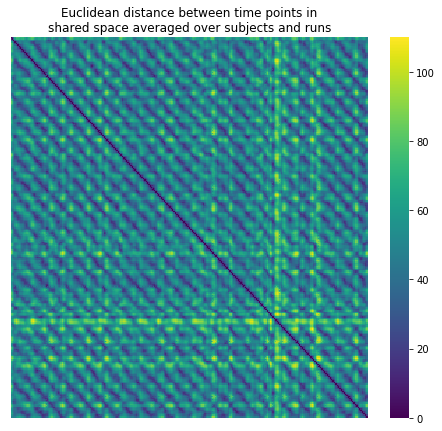

In [299]:
plt.figure(figsize=(8,7))
axis = sns.heatmap(av_timepoint_dist, cbar=True, cmap='viridis')
plt.title("""Euclidean distance between time points in
shared space averaged over subjects and runs""")
axis.set_xticks([])
axis.set_yticks([])
plt.show()

As expected, a dark diagonal indicates neighboring time points are most similar. Also, the periodic pattern is recognizable in the repeating off-diagonal dark patterns.

# Digit-wise distances

In [81]:
test_df = projected_dfs_run1[0]

In [157]:
# add correct digit labels for given run
test_df['digit'] = digit_colors_run1

In [215]:
# prepare results arrays
av_distances = np.zeros(shape=(2, len(projected_dfs_run1), 5 , 5))
std_distances = np.zeros(shape=(2, len(projected_dfs_run1), 5 , 5))

# iterate over runs and subjects
for run_idx in range(2):
    # select correct run and corresponding finger labels
    projected_dfs = [projected_dfs_run1, projected_dfs_run2][run_idx]
    digit_labels = [digit_colors_run1, digit_colors_run2][run_idx]
    for sub_idx in range(len(projected_dfs_run1)):
        # select correct data frame and add digit labels for slicing
        df = projected_dfs[sub_idx]
        df['digit'] = digit_labels
        # iterate over pairs of digits
        for source_digit in range(1,6):
            for target_digit in range(1,6):
                # select subset of data frame for source and target digit (array of shape nsamples, nfeatures)
                source_data = df[df.digit == source_digit].drop(columns=['digit']).values
                target_data = df[df.digit == target_digit].drop(columns=['digit']).values
                # iterate over pairs of samples, compute distance, and save in list
                sample_wise_distances = []
                for source_sample in range(source_data.shape[0]):
                    for target_sample in range(target_data.shape[0]):
                        dist = euclidean(source_data[source_sample], target_data[target_sample])
                        sample_wise_distances.append(dist)
                # compute average and standard deviation of these distances
                av_distances[run_idx, sub_idx, source_digit-1, target_digit-1] = np.average(sample_wise_distances)
                std_distances[run_idx, sub_idx, source_digit-1, target_digit-1] = np.std(sample_wise_distances)

In [272]:
"""
This shall basically be our final result for this matrix
"""

# aggregate (average) over subjects and runs
agg_av_distances = np.average(av_distances, axis=(0,1))
agg_std_distances = np.average(std_distances, axis=(0,1))

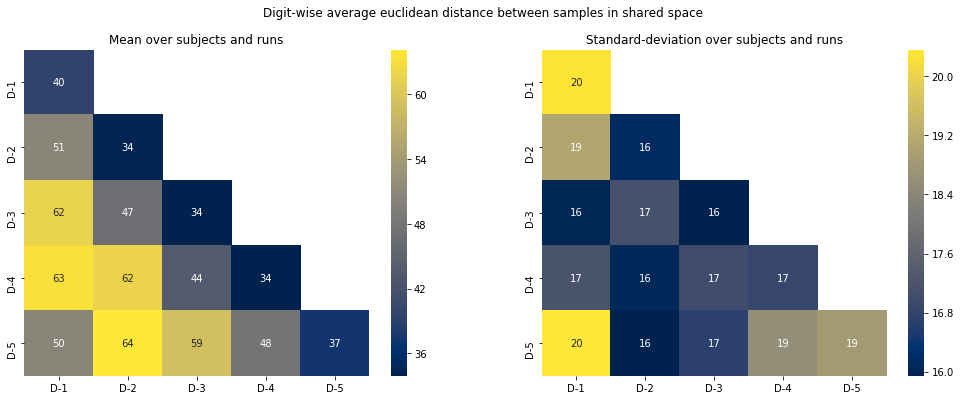

In [295]:
# mask lower triangle (because matrices are symmetric)
tril_mask = np.zeros_like(agg_av_distances, dtype=np.bool)
tril_mask[np.triu_indices_from(tril_mask, k=1)] = True

# start plotting
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(17,6))

digit_strings = ['D-%i' %i for i in range(1,6)]
shared_figkws = {'cmap':'cividis', 'cbar':True, 'annot':True, #'square':True, 
                 'xticklabels':digit_strings, 'yticklabels':digit_strings, 'mask':tril_mask}

sns.heatmap(agg_av_distances_triu, ax=axs[0], **shared_figkws)
sns.heatmap(agg_std_distances_triu, ax=axs[1], **shared_figkws)

plt.suptitle("""Digit-wise average euclidean distance between samples in shared space""")

axs[0].set_title('Mean over subjects and runs')
axs[1].set_title('Standard-deviation over subjects and runs')

plt.show()

The matrix on the left gives us a measure of how distinct the digit clusters are from another. We see what we would want to see: A diagonal of low values indicates that data-points from the same digit-stimulation are more closely located to another in shared space, as compared to data-points from different digit-stimulations.

The matrix on the right gives us a measure of dispersion for the different distance measures. There is merely meant as a sanity check to exclude the possibility that our hypothesized pattern for the left matrix is not merely explained by awkwardly inhomogeneous cluster-variances.